# Init

In [1]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing, visualization
from modules.data_generation import DataGenerator
from modules import filtering, data_projection as dp
import matplotlib.pyplot as plt

logger = logging.getLogger("beta2")
utils.remove_outliers = False

## Load data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [9]:
feature_type = "ca_inv" # "contacts_5_cutoff", "closest-heavy_inv" or "CA_inv", "cartesian_ca", "cartesian_noh"
nclusters = 2
working_dir = os.path.expanduser("~/projects/gpcr/mega/Result_Data/beta2-dror/clustering_D09")
data = np.load("{}/samples/{}/samples.npz".format(working_dir, feature_type))['array']
feature_to_resids = np.load("{}/samples/{}/feature_to_resids.npy".format(working_dir, feature_type))  
cluster_indices = np.loadtxt("{}/clustering_dt10_{}clusters/cluster_indices_.txt".format(working_dir, nclusters))
cluster_indices -= 1 #start at 0 instead of 1
if len(data) != len(cluster_indices) or data.shape[1] != len(feature_to_resids):
    raise Exception()
logger.info("Loaded data of shape %s and %s clusters for %s clusters and feature type %s", data.shape, len(set(cluster_indices)), nclusters, feature_type)

2019-03-05 14:25:09 beta2-INFO: Loaded data of shape (5556, 39624) and 2 clusters for 2 clusters and feature type ca_inv


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [12]:
n_iterations, n_splits = 2, 1
#rbm_data = np.copy(data)
#np.random.shuffle(rbm_data)
filter_by_distance_cutoff, use_inverse_distances = False, False
feature_extractors = [
     fe.MlpFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
                             hidden_layer_sizes=(100,), #, 50, 25),
                             activation="logistic", 
                            use_inverse_distances=use_inverse_distances,
                             randomize=True,
                             filter_by_distance_cutoff=filter_by_distance_cutoff),
    fe.MlpAeFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
                           hidden_layer_sizes=(200, 2, 200), 
                           max_iter=200, 
                            use_inverse_distances=use_inverse_distances,
                           activation="logistic"), #, solver="sgd"), 
     fe.RbmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, 
                          n_components=8,
                          use_inverse_distances=use_inverse_distances,
                          filter_by_distance_cutoff=filter_by_distance_cutoff),                           
#      fe.ElmFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
#                             filter_by_distance_cutoff=filter_by_distance_cutoff,
#                             n_nodes=3000,
#                             use_inverse_distances=use_inverse_distances,
#                             alpha=1, activation="logistic"),
     fe.KLFeatureExtractor(data, cluster_indices, n_splits=n_splits,
                            use_inverse_distances=use_inverse_distances,
                            filter_by_distance_cutoff=filter_by_distance_cutoff),
     fe.PCAFeatureExtractor(data, cluster_indices, n_splits=n_splits,
                            use_inverse_distances=use_inverse_distances,
                           filter_by_distance_cutoff=filter_by_distance_cutoff),
     fe.RandomForestFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
                            use_inverse_distances=use_inverse_distances,
                            filter_by_distance_cutoff=filter_by_distance_cutoff),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


TypeError: __init__() got an unexpected keyword argument 'use_inverse_distances'

# Run the relevance analysis

In [14]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2019-02-06 18:09:02 beta2-INFO: Computing relevance for extractors MLP_AE
2019-02-06 18:09:02 Extracting features-INFO: Performing feature extraction with MLP_AE on data of shape (857, 1000)
2019-02-06 18:09:02 Extracting features-INFO: Using all data in training and validation sets
2019-02-06 18:09:02 mlp_ae-DEBUG: Training MLP with 857 samples and 1000 features ...
2019-02-06 18:09:22 mlp_ae-DEBUG: Extracting feature importance using MLP Autoencoder ...
2019-02-06 18:09:22 mlp-DEBUG: Extracting feature importance using MLP ...
2019-02-06 18:09:22 mlp-DEBUG: Rescaling feature importance extracted using MLP in each frame between min and max ...
2019-02-06 18:09:22 Extracting features-INFO: Done with MLP_AE
2019-02-06 18:09:22 Extracting features-INFO: ------------------------------
2019-02-06 18:09:22 beta2-INFO: Done


# Remap and persist results 

In [15]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir, 
                                     pdb_file=working_dir + "analysis/all_orig.pdb",
                                     feature_to_resids=feature_to_resids, filter_results=True)
    p.average()
    p.evaluate_performance()
    p.persist()
    postprocessors.append([p])
logger.info("Done")


2019-02-06 18:11:28 utils-INFO: Rescaling feature importances ...
2019-02-06 18:11:28 filtering-INFO: Filtering feature importances by median ...
2019-02-06 18:11:28 utils-INFO: Rescaling feature importances ...
2019-02-06 18:11:28 utils-INFO: Rescaling feature importances ...
2019-02-06 18:11:28 projection-INFO: Scoring raw projections.
2019-02-06 18:11:29 postprocessing-WARNING: importance is None for residues set([1, 130, 228, 6, 8, 265, 2, 13, 17, 18, 51, 21, 22, 9, 345, 15])
2019-02-06 18:11:29 postprocessing-WARNING: importance is None for residues set([1, 130, 228, 6, 8, 265, 2, 13, 17, 18, 51, 21, 22, 9, 345, 15])
2019-02-06 18:11:30 beta2-INFO: Done


# Visualize results

2019-02-06 18:11:30 utils-INFO: Rescaling feature importances ...


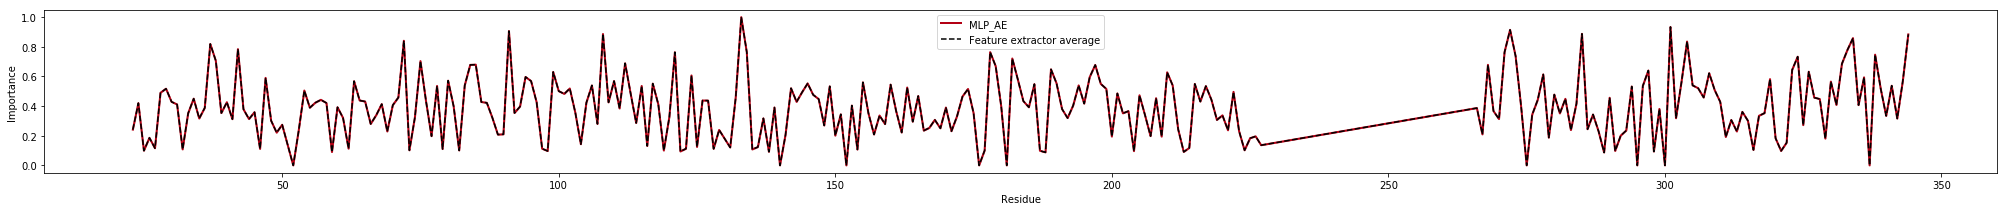

2019-02-06 18:11:30 beta2-INFO: Done. The settings were n_iterations, n_splits = 1, 1.
Filtering (filter_by_distance_cutoff = False)


In [16]:
visualization.visualize(postprocessors,
          show_importance=True, 
          show_performance=False, 
          show_projected_data=False)

logger.info("Done. The settings were n_iterations, n_splits = %s, %s.\nFiltering (filter_by_distance_cutoff = %s)", 
            n_iterations, n_splits, filter_by_distance_cutoff)